**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Optimal taxation with government consumption](#toc1_)    
- 2. [Problem 2: Labor adjustment costs](#toc2_)    
- 3. [Problem 3: Global optimizer with refined multi-start](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [27]:
# Importing relevant packages
import sympy as sm
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"-"}) 
from scipy import optimize
from types import SimpleNamespace

## 1. <a id='toc1_'></a>[Problem 1: Optimal taxation with government consumption](#toc0_)


Consider a worker choosing hours of labor, $L\in[0,24]$, to maximize utility: 

$$
\begin{align*}
V(w,\tau,G)&=\max_{L\in[0,24]}\ln\left(C^{\alpha}G^{1-\alpha}\right)-\nu\frac{L^{2}}{2}\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}
$$

where 

* $C$ is *private* consumption with weight $\alpha\in(0,1)$.
* $\kappa > 0$ is the *free private* consumption component.
* $C = (1-\tau)wL$ is the *costly private* consumption component.
* $w > 0 $ is the real wage.
* $\tau \in (0,1)$ is the labor-income tax rate.
* $G > 0 $ is *government* consumption with weight $1-\alpha$.
* $\nu > 0$ is the disutility of labor scaling factor


The baseline parameters are:

$$
\begin{align*}
\alpha &= 0.5\\
\kappa &= 1.0\\
\nu &= \frac{1}{2\cdot16^2} \\
w &= 1.0 \\ 
\tau &= 0.30 \\
\end{align*}
$$

**Question 1:** Verify that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

**1.1.1** We are defining the functions in symbolic math

In [3]:
# Defining symbols
C = sm.symbols('C') 
G = sm.symbols('G')
L = sm.symbols('L')
alpha = sm.symbols('alpha')
kappa = sm.symbols('kappa')
nu = sm.symbols('nu')
w = sm.symbols('w')
tau = sm.symbols('tau')
#Using this to get a tilde over the w. 
sm.init_printing()
wtilde= sm.symbols("wtilde ")

# write out the consumer utility function
utility = sm.log(C**alpha*G**(1-alpha))-nu*L**2/2

#Budget constraint
budget = sm.Eq(C, kappa+wtilde*L)


**1.1.2** Isolate and Substitute

In [4]:
#Isolate (necessary since sympy otherwise does not work)
C_from_con = sm.solve(budget, C)
C_from_con[0]

#Substitute into utility function
objective = utility.subs(C, C_from_con[0])
objective


**1.1.3** Finding FOC wrt. L

In [5]:
#Finding the FOC
foc = sm.Eq(sm.diff(objective, L),0)
foc

**1.1.4** Solving for L in the equation

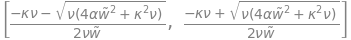

In [6]:
L_star = sm.solve(foc, L)
L_star

We note that $L^{\star}$ cannot be negative, so only the second solution holds. That is:

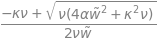

In [7]:
L_star[1]

We have shown the result now. $\nu$ can be simplified away (The square root can be rewritten, so we have $\nu^2$ and then we have a $\nu$ in all terms, and hereby it can be removed), and we get the following expression for the optimal labor supply:

$L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$

G is not important since we are taking the log. Hereby it will not influence in this case, as it is not dependent on $\tau$. However, this will of course change in exercise 1.3. 

**Question 2:** Illustrate how $L^{\star}(\tilde{w})$ depends on $w$.

**1.2.1** Substitute w into the expression for $L^*$

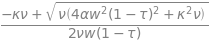

In [8]:
# Defining wtilde
wtilde_func=sm.Eq(wtilde,(1-tau)*w)
wtilde_from_con = sm.solve(wtilde_func, wtilde)
wtilde_from_con [0]

#Substitute into L_star
L_star_w = L_star[1].subs(wtilde, wtilde_from_con[0])
L_star_w

**1.2.2** Lambdify the function

In [9]:
#Create function
sol_L = sm.lambdify(args=(kappa,nu,alpha,w,tau),expr=L_star_w)

#Defining the baseline parameters
alpha_val=0.5
kappa_val=1.0
nu_val=(2.0*16.0**2.0)**(-1.0)
tau_val=0.3

#Create a grid for w. We don't start from 0, because then we get a division by zero error.
w_vec=np.linspace(0.1,5.0,100)

#Run sol_func
L_w=sol_L(kappa_val,nu_val,alpha_val,w_vec,tau_val)

**1.2.3** Plotting the results

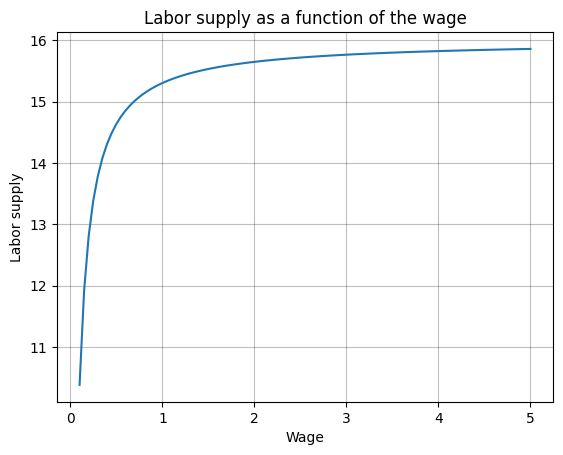

In [10]:
#Create the figure
fig = plt.figure()

#Add subplot
ax = fig.add_subplot(1,1,1)

#Plot labor supply as a function of the wage
ax.plot(w_vec,L_w)

#Add title and axis labels
ax.set_title('Labor supply as a function of the wage')
ax.set_xlabel('Wage')
ax.set_ylabel('Labor supply')

plt.show()

Here we see that labor supply is increasing in wage, but that the relationship is concave. This makes sense intuitively: If the worker receives a higher wage, then worker would like to work more, however the worker also receives relatively increasing disutility from working, so the effect wears off.


We now consider a government, who chooses $\tau$ and spend all of the taxes on government consumption so:

$$
G = \tau w L^{\star}((1-\tau)w)
$$

**Question 3:** Plot the implied $L$, $G$ and worker utility for a grid of $\tau$-values.


**1.3.1** Define G and lambdify the function

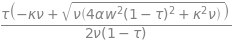

In [11]:
#Define G as a function of optimal L*:
G_new = tau*w*L_star_w
G_new

In [12]:
#Lambdify
sol_G = sm.lambdify(args=(kappa,nu,alpha,w,tau),expr=G_new)

**1.3.2** Define worker utility and lamdify

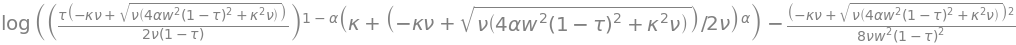

In [13]:
#Define utility as a function of optimal L* and G:
utility = sm.log((kappa+(1-tau)*w*L_star_w)**alpha*G_new**(1-alpha))-nu*L_star_w**2/2
utility

In [14]:
#lambdify
sol_utility = sm.lambdify(args=(kappa,nu,alpha,w,tau),expr=utility)

**1.3.3** Define parameters

Now we're interested in the relationship between tau and L, G and utility respectively. Therefore wage we set to it's baseline value and we specify $\tau$ as a vector.

In [15]:
#Baseline w
w_val = 1.0

#Vector of tau. Cannot be 0 or 1.
tau_vec = np.linspace(0.05,0.95,100)

**1.3.4** Run functions

In [115]:
#labor supply
L_tau = sol_L(kappa_val,nu_val,alpha_val,w_val,tau_vec)

#government consumption
G_tau = sol_G(kappa_val,nu_val,alpha_val,w_val,tau_vec)

#utility
u_tau = sol_utility(kappa_val,nu_val,alpha_val,w_val,tau_vec)

array([1.01499117, 1.09385915, 1.16070663, 1.21854056, 1.26936015,
       1.31456221, 1.35516106, 1.39191652, 1.42541243, 1.45610703,
       1.48436655, 1.51048822, 1.53471651, 1.55725492, 1.57827455,
       1.5979206 , 1.61631731, 1.63357173, 1.64977677, 1.66501347,
       1.67935296, 1.69285792, 1.70558386, 1.71758013, 1.72889074,
       1.7395551 , 1.74960855, 1.75908292, 1.76800688, 1.77640635,
       1.78430479, 1.79172345, 1.7986816 , 1.80519673, 1.81128473,
       1.81696   , 1.82223562, 1.82712343, 1.83163415, 1.83577747,
       1.83956208, 1.84299579, 1.84608555, 1.84883753, 1.85125713,
       1.85334904, 1.85511725, 1.85656511, 1.85769531, 1.85850994,
       1.85901046, 1.85919774, 1.85907205, 1.85863307, 1.85787988,
       1.85681095, 1.85542416, 1.85371673, 1.85168526, 1.84932565,
       1.84663312, 1.84360215, 1.84022646, 1.83649893, 1.83241157,
       1.82795546, 1.82312068, 1.81789621, 1.81226984, 1.80622809,
       1.79975604, 1.79283721, 1.78545341, 1.77758451, 1.76920

**1.3.5** Plotting the results

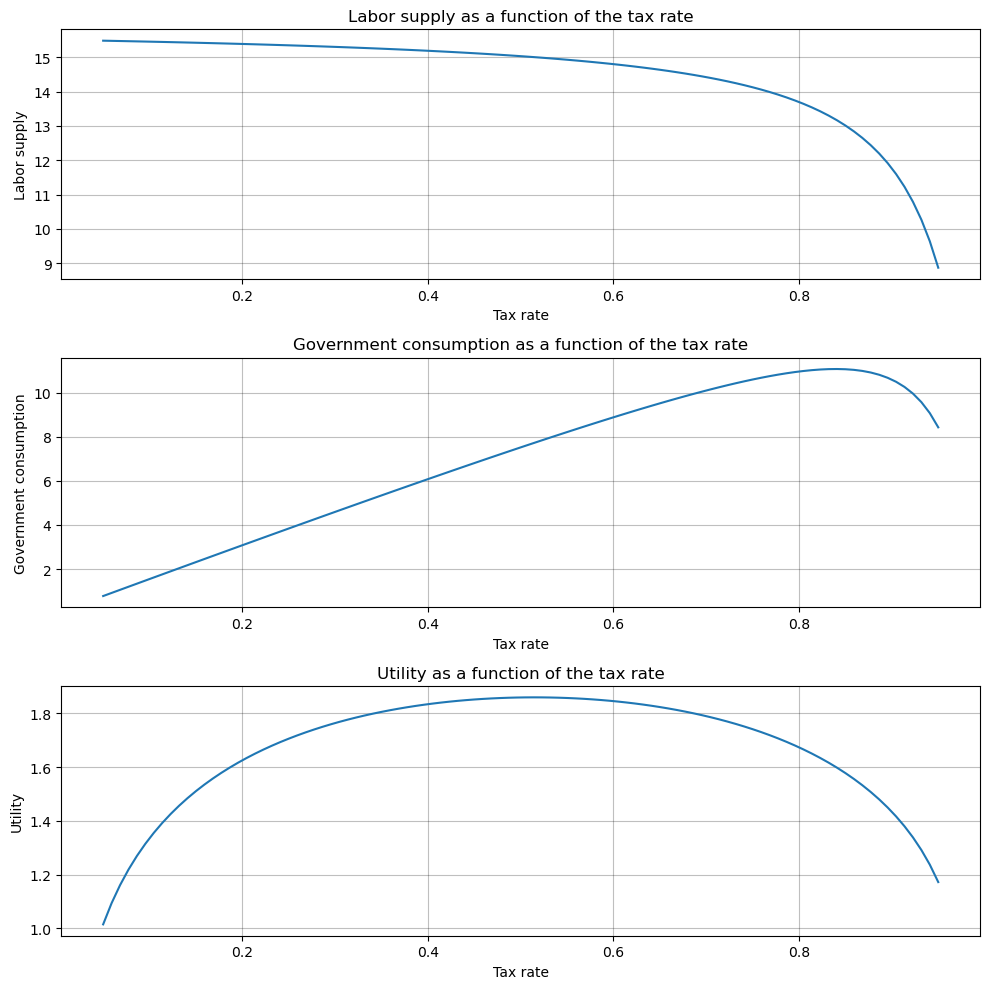

In [ ]:
#Create the figure
fig = plt.figure(figsize=(10,10))

# a. Labor supply
ax = fig.add_subplot(3,1,1)
ax.plot(tau_vec,L_tau)
ax.set_title('Labor supply as a function of the tax rate')
ax.set_xlabel('Tax rate')
ax.set_ylabel('Labor supply')

#b. Government consumption
ax = fig.add_subplot(3,1,2)
ax.plot(tau_vec,G_tau)
ax.set_title('Government consumption as a function of the tax rate')
ax.set_xlabel('Tax rate')
ax.set_ylabel('Government consumption')

#c. Utility
ax = fig.add_subplot(3,1,3)
ax.plot(tau_vec,u_tau)
ax.set_title('Utility as a function of the tax rate')
ax.set_xlabel('Tax rate')
ax.set_ylabel('Utility')

plt.tight_layout()
plt.show()

First, we see that the labor supply is decreasing in the tax rate. This makes intuitive sense, since a higher tax rate implies a lower disposable income, which reduces the incentive to work. 

Second, we see that government consumption is initially increasing in the tax rate and then around $\tau = 0.8$ it turns to be decreasing. This makes sense, as this is essentially the Laffer curve: There is both a mechanical and a behavioral effect. Mechanically, an increase in the taxrate means a higher taxrevenue for a given behavoir. Behaviorally, as we saw above an increase in tax rate means that the worker works less.

Finally, we see that utility is effectively a downward pointing second degree polynomial in the tax rate. This also makes sense, as the worker gets utility from both working and from government consumption and there is an inverse relationship between the two.

**Question 4:** Find the socially optimal tax rate $\tau^{\star}\in(0,1)$ maximizing worker utility. Illustrate your result.

In [101]:
class ConsumerProblemCobbDouglas():
    def __init__(self):

        "Initial parameters. They can be changed as seen with beta and sigma"

        par = self.par = SimpleNamespace()

        # a. parameters

        par.alpha=0.5
        par.kappa = 1.0
        par.nu = 1/(2.0*16.0**2.0)
        par.w=1

    def consumption_constraint(self,L,tau):

        par = self.par
        
        return par.kappa+(1-tau)*par.w*L
    
    def government_constraint(self,L,tau): 
        
        par = self.par
        return par.w*tau*L

    def disutility(self,L): 
         par = self.par
         return par.nu*L**2/2

    def utility(self,L,tau):
        par = self.par

        utility = np.log(self.consumption_constraint(L,tau)**par.alpha*self.government_constraint(L,tau)**(1-par.alpha))-self.disutility(L)

        return -utility

    def utility_optimize(self,x):

        #Rewriting the function in order to get a constraint later on. 
        return self.utility(x[0],x[1])

    def maximize_utility(self): 

            # a. setup

            #The bounds as before. Consumption cannot be negative. 
            bounds = ((0,24),(0,1))

            # b. initial guess
            x0 = (15,0.3)

            #Important that we have the constraint as this is the condition in the problem. 
            result = optimize.minimize(self.utility_optimize,x0,

                                        method='L-BFGS-B',

                                        bounds=bounds,

                                        options={'disp':True})

            L_star = result.x[0]
            tau_star = result.x[1]

            #c. output
            return L_star, tau_star

test=ConsumerProblemCobbDouglas()
L_optimal,tau_optimal=test.maximize_utility()

print(f' The optimal labor supply is = {L_optimal:.5f} with the optimal tax rate being = {tau_optimal:.5f}')

test.utility(L_optimal,tau_optimal)
#test.disutility(L_optimal)


 The optimal labor supply is = 22.13292 with the optimal tax rate being = 0.52259


In [123]:
class WorkerClass:
    def __init__(self):
        self.par = SimpleNamespace()

        # Parameters
        self.par.alpha = 0.5
        self.par.kappa = 1.0
        self.par.nu = (2.0 * 16.0 **2.0) ** (-1.0)
        self.par.w = 1.0

    def consumption_constraint(self, L, tau):
        par = self.par
        return par.kappa + (1 - tau) * par.w * L

    def government_constraint(self, L, tau):
        par = self.par
        return tau * par.w * L

    def utility(self, L, tau):
        par = self.par
        return -(np.log(self.consumption_constraint(L, tau) ** par.alpha *
                        self.government_constraint(L, tau) ** (1 - par.alpha)) -
                 par.nu * L ** 2 / 2)

    def utility_optimize(self, tau):
        par = self.par
        
        bounds = [(0, 24)]  # Define the bounds as a list of tuples
        result = optimize.minimize(self.utility, x0=5, bounds=bounds, args=(tau,))
        L_opt = result.x[0]
        return L_opt
    
    def tau_optimize(self):
        bounds = [(0, 1)]  # Define the bounds as a list of tuples
        result = optimize.minimize(self.utility_optimize, x0=0.5, bounds=bounds)
        tau_opt = result.x[0]

test_2 = WorkerClass()
test_2.utility_optimize(0.52)

In [124]:
class WorkerClass_v2:
    def __init__(self):
        self.par = SimpleNamespace()

        # Parameters
        self.par.alpha = 0.5
        self.par.kappa = 1.0
        self.par.nu = (2.0 * 16.0 ** 2.0)**(-1.0)
        self.par.w = 1.0
    
    def consumption_constraint(self,L,tau):

        par = self.par
        
        return par.kappa+(1-tau)*par.w*L

    def government_constraint(self, L, tau):
        par = self.par
        return tau * par.w * L

    def disutility(self,L): 
         par = self.par
         return par.nu*L**2/2

    def target(self, params):
        par = self.par
        L_optimal,tau_optimal = params

        #Running the regression with the target values, where the target values are those to be optimized. 
        C_optimal = self.consumption_constraint(L_optimal,tau_optimal)
        G_optimal =  self.government_constraint(L_optimal,tau_optimal)
        disutility_optimal = self.disutility(L_optimal)


        return -np.log(C_optimal**par.alpha*G_optimal**(1-par.alpha))+disutility_optimal

    def solve_optimal_alpha_sigma(self):
        """ This is to find optimal value of alpha and sigma for question 4
        We use Nelder-Mead because we do not have constraints"""

        #Defining the initial guess based on the seed. 
        init_guess = [(5,0.5)]

        #Bounds for alpha and sigma. 
        bounds = [(0.01, 24), (0.01,0.99)]

        result = optimize.minimize(self.target,init_guess, method='SLSQP', bounds=bounds)

        #Saving result from the optimizer. 
        L_optimal, tau_optimal = result.x

        #Saving the results in one parameter in order to include in target function. 
        params_result=L_optimal,tau_optimal

        #Returning the values. 
        return L_optimal, tau_optimal, self.target(params_result)   
    
test_3=WorkerClass_v2()
test_3.solve_optimal_alpha_sigma()

C:\Users\Ander\AppData\Local\Temp\ipykernel_20688\809052739.py:47: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  result = optimize.minimize(self.target,init_guess, method='SLSQP', bounds=bounds)


A more general preference formulation for the worker is:

$$
\begin{align*}
\mathcal{V}(w,\tau,G)&=\max_{L\in[0,24]}\frac{\left[ \left( \alpha C^{\frac{\sigma-1}{\sigma}}+(1-\alpha) G^{\frac{\sigma-1}{\sigma}} \right)^{\frac{\sigma}{1-\sigma} }\right]^{1-\rho}-1}{1-\rho}- \nu\frac{L^{1+\varepsilon}}{1+\varepsilon},\,\,\,\varepsilon,\rho,\sigma>0,\,\,\,\rho,\sigma\neq1\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}    
$$

Optimal labor supply is now $L^{\star}(\tilde{w},G)$.

Questions 5 and 6 must be answered with the general formulation, and for 2 different set of parameters:

- Set 1:  $\sigma = 1.001$, $\rho = 1.001$ and $\varepsilon = 1.0$.
- Set 2:  $\sigma = 1.5$, $\rho = 1.5$ and $\varepsilon = 1.0 $.

**Question 5:** Find the $G$ that solves $G = \tau w L^{\star}((1-\tau)w,G)$ using the $\tau$ found in question 4.

*Hint: First write code that solves the worker problem for given values of $G$ and $\tau$. Then find the correct G based on this.*

In [ ]:
# write your code here

**Question 6:** Find the socially optimal tax rate, $\tau^{\star}$, maximizing worker utility, while keeping $G = \tau w L^{\star}((1-\tau)w,G)$.

In [ ]:
# write your code here  

## 2. <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

You own a hair salon. You employ hairdressers, $\ell_t$, to produce haircuts, $y_t = \ell_t$.

The wage for each haridresser is $w$.

The demand for haircuts implies that the price of haircuts you can charge is $p_t = \kappa_t y_t^{-\eta}$, where $\kappa_t$ is a demand-shock and $\eta \in (0,1)$ measures the elasticity of demand.

Profits are:

$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$

Baseline parameters are:
- $\eta = 0.5$
- $w = 1.0$

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

In [ ]:
# write your code here

We now consider a *dynamic* version of the model.

* The demand-shock is a so-called AR(1) in logs, 

$$
\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t},\,\,\, \epsilon_{t+1} \sim \mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})
$$

* Any hiring or firing implies a fixed adjustment cost, $\iota > 0 $.
* Future profits are discounted with a monthly factor of $R \in (0,1)$.

The initial demand shock is $\kappa_{-1} = 1$ and the planning horizon is 10 years, i.e. 120 months so $t \in \{0,1,2,\dots,119\}$. Initially you don't have any employees, $\ell_{-1}=0$


The *ex post* value of the salon is *conditional* on the shock series is:

$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]\right]
$$

The *ex ante* expected value of the salon can be approximated by

$$
H = \mathbb{E}[h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119})] \approx \frac{1}{K}\sum_{k=0}^{K} h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)
$$

where each $k\in\{0,1,\dots,K-1\}$ is a random shock series. Maximizing profitability means maximizing $H$.


Baseline parameters are: 

- $\rho = 0.90$
- $\iota = 0.01$
- $\sigma_{\epsilon} = 0.10$
- $R = \left(1+0.01\right)^{1/12}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

In [ ]:
# write your code here 

Next, we consider policies on the form:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.



**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

In [ ]:
# write your code here

**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

In [ ]:
# write your code here


**Question 5:** Suggest an alternative policy you believe might improve profitability. Implement and test your policy.



In [ ]:
# write your code here

## 3. <a id='toc3_'></a>[Problem 3: Global optimizer with refined multi-start](#toc0_)

We consider the Griewank function:

$$ f(\boldsymbol{x}) = \sum^n_{i=1} \frac{x^2_i}{4000}-\prod^n_{i=1}\cos\left(\frac{x_i}{\sqrt{i}}\right)+1$$

The **global minimum** of this function is $f(0,0) = 0$ (remember: $\cos(0)=1$).<br>
But the function also have a lot of **local minima**.

In [ ]:
def griewank(x):
    return griewank_(x[0],x[1])
    
def griewank_(x1,x2):
    A = x1**2/4000 + x2**2/4000
    B = np.cos(x1/np.sqrt(1))*np.cos(x2/np.sqrt(2))
    return A-B+1

A **refined global optimizer with multi-start** is:

1. Choose *bounds* for $\mathbf{x}$ and *tolerance* $\tau > 0$.
2. Choose number of *warm-up iterations*, $\underline{K} > 0$ and *maximum number of iterations*, $K > \underline{K}$.
3. In each iteration for $k \in \{0,1,\dots,K-1\}$:

    A. Draw random $\mathbf{x}^k$ uniformly within chosen bounds.

    B. If $k < \underline{K}$ go to step E.

    C. Calculate $\chi^k = 0.50\cdot\frac{2}{1+\exp((k-\underline{K})/100)}$  

    D. Set $\mathbf{x}^{k0} = \chi^k \mathbf{x}^k + (1-\chi^k)\mathbf{x}^{\ast} $

    E. Run optimizer with $\mathbf{x}^{k0}$ as initial guess and $\mathbf{x}^{k\ast}$ as result.

    F. Set $\mathbf{x}^{\ast} = \mathbf{x}^{k\ast}$ if $k = 0$ or $f(\mathbf{x}^{k\ast}) < f(\mathbf{x}^{\ast})$

    G. If $f(\mathbf{x}^{\ast}) < \tau$ go to step 4.

4. Return the result $\mathbf{x}^{\ast}$.

As settings we choose:

* $x_1,x_2 \in  [-600,600]$
* $\tau = 10^{-8}$
* $\underline{K}=10$
* $K=1000$

The optimizer in Step 3.E is `BFGS` with a tolerance of $\tau$.

**Question 1:** Implement the refined global optimizer with multi-start. Illustrate how the effective initial guesses $\mathbf{x}^{k0}$ vary with the iteration counter $k$.

In [ ]:
# write your code here

**Question 2:** Is it a better idea to set $\underline{K} = 100$? Is the convergence faster?

In [ ]:
# write your code here